In [1]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


In [2]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [67]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/" + x
ds_forced = xr.open_dataset(datadir("SO_Tracer_Hov_forced_w_sigma2.nc"))
ds_ctrl = xr.open_dataset(datadir("SO_Tracer_Hov_control_w_sigma2.nc"))
ds_ctrl.coords["time"] = ds_forced.time.values

min_year = 1950; max_year = None
ds_forced = ds_forced.rename({"Z_l":"z"}).groupby("time.year").mean("time")
ds_forced = ds_forced.sel(year = slice(min_year, None))

ds_ctrl = ds_ctrl.rename({"Z_l":"z"}).groupby("time.year").mean("time")
ds_ctrl = ds_ctrl.sel(year = slice(min_year, None))


In [68]:
#define sigma levels
siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.sort(np.append(siglevels, [37.11, 37.21, 37.22, 37.23, 37.24]))
siglevels

array([36.2 , 36.4 , 36.6 , 36.8 , 37.  , 37.11, 37.2 , 37.21, 37.22,
       37.23, 37.24])

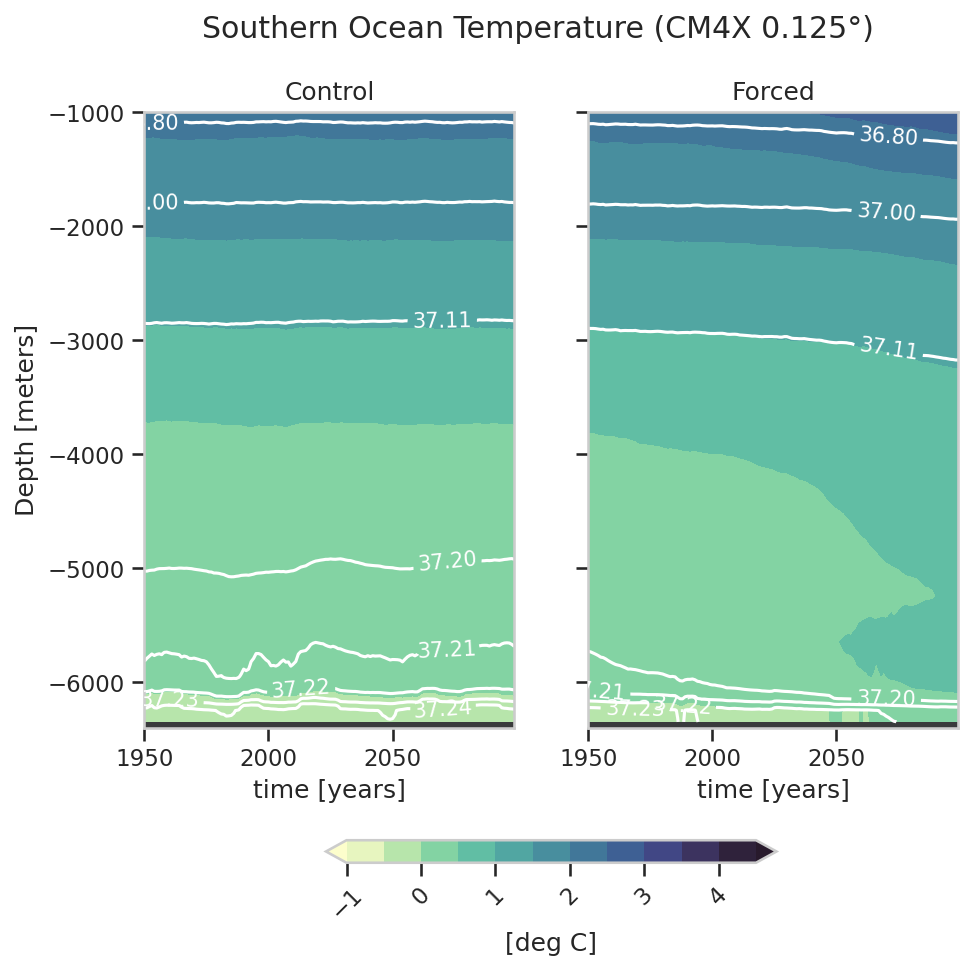

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = True)
levels = np.arange(-1, 5, 0.5)
tracer = "thetao"; tracername = "Temperature"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

def plot_temperature(ds, ax, tracer, levels, siglevels): 
    tmp1 = ds[[tracer, "sigma2"]]
    cntf = ax.contourf(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.deep, extend = "both", levels = levels)
    cnt = ax.contour(tmp1.year, tmp1.z, tmp1.sigma2.T, levels = siglevels, colors = "white");
    cs = ax.clabel(cnt, inline=True, fontsize=10)
    return cntf, cnt, cs

cntf, cnt, cs = plot_temperature(ds_ctrl, ax[0], tracer, levels, siglevels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

cntf, cnt, cs = plot_temperature(ds_forced, ax[1], tracer, levels, siglevels)
# ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -1000) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cntf, ax = ax[0:2], label = f"[{variable_kwargs[tracer]["units"]}]", 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)

# fig.savefig(plotsdir("paper_figures/SouthernOceanTemperature.png"), bbox_inches = "tight", dpi = 100)

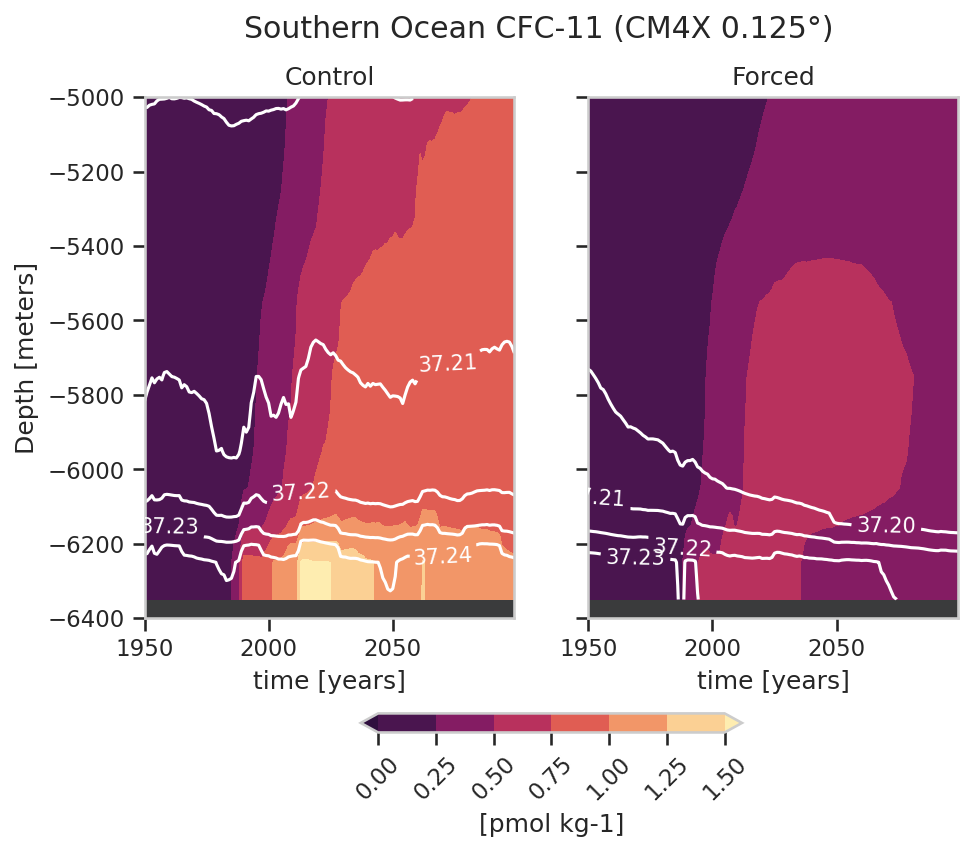

In [78]:
fig, ax = plt.subplots(1, 2, figsize = (7, 5.5), sharey = True)
levels = np.arange(0, 1.51, 0.25)
tracer = "cfc11"; tracername = "CFC-11"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

def plot_tracer(ds, ax, tracer, levels, siglevels): 
    tmp1 = ds[[tracer, "sigma2"]]
    tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
    tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)
    cntf = ax.contourf(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.matter_r, extend = "both", levels = levels)
    cnt = ax.contour(tmp1.year, tmp1.z, tmp1.sigma2.T, levels = siglevels, colors = "white");
    cs = ax.clabel(cnt, inline=True, fontsize=10)
    return cntf, cnt, cs

cntf, cnt, cs = plot_tracer(ds_ctrl, ax[0], tracer, levels, siglevels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

cntf, cnt, cs = plot_tracer(ds_forced, ax[1], tracer, levels, siglevels)
# ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -5000) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cntf, ax = ax[0:2], label = f"[{variable_kwargs[tracer]["units"]}]", 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)
# fig.savefig(plotsdir("paper_figures/SouthernOceanCFC11.png"), bbox_inches = "tight", dpi = 100)

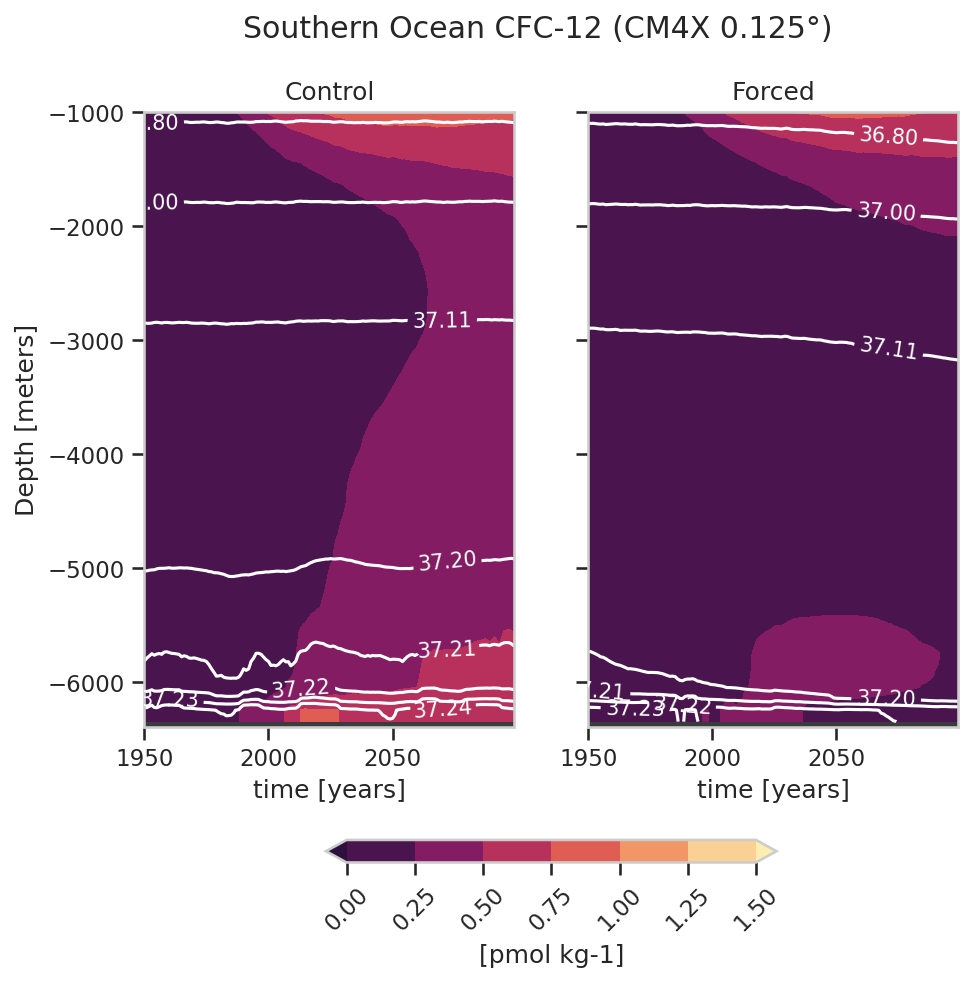

In [75]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = True)
levels = np.arange(0, 1.51, 0.25)
tracer = "cfc12"; tracername = "CFC-12"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

def plot_tracer(ds, ax, tracer, levels, siglevels): 
    tmp1 = ds[[tracer, "sigma2"]]
    tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
    tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)
    cntf = ax.contourf(tmp1.year, tmp1.z, tmp1[tracer].T, cmap = cmo.matter_r, extend = "both", levels = levels)
    cnt = ax.contour(tmp1.year, tmp1.z, tmp1.sigma2.T, levels = siglevels, colors = "white");
    cs = ax.clabel(cnt, inline=True, fontsize=10)
    return cntf, cnt, cs

cntf, cnt, cs = plot_tracer(ds_ctrl, ax[0], tracer, levels, siglevels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

cntf, cnt, cs = plot_tracer(ds_forced, ax[1], tracer, levels, siglevels)
# ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -1000) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cntf, ax = ax[0:2], label = f"[{variable_kwargs[tracer]["units"]}]", 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)
# fig.savefig(plotsdir("SouthernOceanCFC12.png"), bbox_inches = "tight", dpi = 100)